In [68]:
import pandas as pd
# Load extracted Truth Social post features
df_feature = pd.read_csv('truthsocial_posts_analysis.csv')

In [69]:
# Keep only rows with valid author and text
df = df_feature.dropna(subset=["author", "text"]).copy()

# Ensure text column is string type (important for embedding model)
df["text"] = df["text"].astype(str)

print("Posts:", len(df))
print("Users:", df["author"].nunique())

Posts: 596758
Users: 2850


In [5]:
!pip install sentence-transformers

  Using cached sentence_transformers-5.2.2-py3-none-any.whl.metadata (16 kB)
  Using cached transformers-5.0.0-py3-none-any.whl.metadata (37 kB)
  Using cached filelock-3.20.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached tokenizers-0.22.2-cp39-abi3-macosx_11_0_arm64.whl.metadata (7.3 kB)
  Using cached typer_slim-0.21.1-py3-none-any.whl.metadata (16 kB)
  Using cached safetensors-0.7.0-cp38-abi3-macosx_11_0_arm64.whl.metadata (4.1 kB)
  Using cached fsspec-2026.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-macosx_11_0_arm64.whl.metadata (4.9 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
Using cached sentence_transformers-5.2.2-py3-none-any.whl (494 kB)
Using cached transform

In [70]:
# Sentence embeddings

from sentence_transformers import SentenceTransformer
import numpy as np

# Load a lightweight but strong sentence embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")  

# Encode all posts into dense vectors
embeddings = model.encode(
    df["text"].tolist(),
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True  # cosine space
)

print("Embedding shape:", embeddings.shape)


Loading weights: 100%|█████████████████████████████████████████████| 103/103 [00:00<00:00, 1788.57it/s, Materializing param=pooler.dense.weight]
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 9325/9325 [23:51<00:00,  6.52it/s]


Embedding shape: (596758, 384)


In [71]:
# Topic modeling with NMF
from sklearn.decomposition import NMF

# Number of latent topics to extract
N_TOPICS = 20  

# Initialize Non-negative Matrix Factorization
nmf = NMF(
    n_components=N_TOPICS,
    init="nndsvda",
    random_state=42,
    max_iter=300
)

# NMF requires non-negative input → clamp negatives to 0
W = nmf.fit_transform(np.maximum(embeddings, 0)) 

/Users/sargun/Desktop/truth social/venv311/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1720: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


In [72]:
# Create topic columns (topic_0 ... topic_19)
topic_cols = [f"topic_{i}" for i in range(N_TOPICS)]
df_topics = pd.DataFrame(W, columns=topic_cols)

# Attach topic mixture weights back to the main dataframe
df = pd.concat([df.reset_index(drop=True), df_topics], axis=1)

# Normalize topic weights so each row sums to 1 (mixture proportions)
df[topic_cols] = df[topic_cols].div(df[topic_cols].sum(axis=1), axis=0)

df.head()

,Unnamed: 0.1,Unnamed: 0,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,...,0.0,0.191007,0.000000,0.126571,0.000000,0.000000,0.000000,0.321292,0.000000,0.145132
1,1,1,807614,6,20054,0,0,0,enough is enough! retruth,0,...,0.0,0.001888,0.083500,0.000000,0.000000,0.018145,0.090782,0.000000,0.105097,0.317538
2,2,2,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,...,0.0,0.000000,0.073789,0.100164,0.202165,0.000000,0.000000,0.153599,0.105702,0.000000
3,3,3,807622,6,20054,0,0,0,<emoji: dart><emoji: 100><emoji: us>,0,...,0.0,0.000000,0.003429,0.000000,0.065548,0.000000,0.000000,0.516513,0.033902,0.000000
4,4,4,807625,5,20054,0,0,0,#truth #soros #ukraine,0,...,0.0,0.000000,0.000000,0.026003,0.630971,0.070343,0.000000,0.000000,0.000000,0.074992


In [73]:
print("df rows:", len(df))
print("W rows:", W.shape[0])
print("Any NaNs in topics:", df[[c for c in df.columns if c.startswith("topic_")]].isna().any().any())


df rows: 596758
W rows: 596758
Any NaNs in topics: False


In [74]:
# Reset index to keep everything aligned
df = df.reset_index(drop=True)

In [75]:
# Extract representative posts per topic
TOP_K = 15
topic_examples = {}

# For each topic, select the TOP_K posts with highest topic score
for i in range(N_TOPICS):
    scores = df[f"topic_{i}"].to_numpy()
    top_idx = np.argsort(scores)[-TOP_K:][::-1]
    topic_examples[i] = df.iloc[top_idx]["text"].tolist()


In [76]:
# Example: inspect topic 3
topic_examples[3]

['escape south when you can.',
 'would be awesome but will never happen.',
 'would be awesome but will never happen.',
 'time to flee the cities.',
 'we gotta dig our way back to freedom.',
 'if we lose freedom here, there is no place to escape to. this is the last stand on earth.',
 'if we lose freedom here, there is no place to escape to. this is the last stand on earth.',
 'if we lose freedom here, there is no place to escape to. this is the last stand on earth.',
 'we live in the land of reboots. what show would you want rebooted ?',
 'we might then have a government that represents the people!!!',
 'what would our founding fathers do? they’d fight like hell and take it back!!!!!!!<emoji: boom><emoji: boom><emoji: boom><emoji: boom><emoji: us>',
 'would you ever consider living out of a van to travel for a period of time? if so, how long could you do it? <emoji: camera_with_flash> steffi.outbound',
 'well, why not destroy the left and rebuild and preserve our country!!!<emoji: us>'

In [77]:
# Print posts per topic for sanity check
for i in range(20):
    print(f"\n=== Topic {i} ===")
    for t in topic_examples[i][:3]:
        print("-", t[:200])


=== Topic 0 ===
- hope they never have a high speed chase - they would lose!
- i’m afraid they will all escape
- the people's convoy has completed its 2,600-mile, 11-day journey across the us, rolling into the capital just days ago. the protesters are now driving around the national mall and through dc honking t

=== Topic 1 ===
- <emoji: grin><emoji: two_hearts><emoji: +1>
- <emoji: hearts> <emoji: hearts>
- <emoji: hearts><emoji: hearts>

=== Topic 2 ===
- flaming espinas tgs 2022 demo - monster hunter rise: sunbreak
- ah, yes! definitely in the coming spotlight i’d think.
- netflix lands hunter x hunter, berserk, and more classic anime

=== Topic 3 ===
- escape south when you can.
- would be awesome but will never happen.
- would be awesome but will never happen.

=== Topic 4 ===
- i wonder who will keep them in their houses? the defunded crooked cops? who only see americans as their enemies and not antifa or blm
- the fbi are the democrat storm troopers. antifa and blm are their b

In [78]:
# Topic labeling using LLM (Ollama)
import subprocess

def label_topic_with_ollama(
    texts,
    model="llama3",
    max_chars=300
):
    # Trim each post to avoid overly long prompts
    texts = [t[:max_chars].replace("\n", " ") for t in texts]

    # Prompt engineered to force short, clean labels
    prompt = (
        "You are labeling a topic from social media posts.\n\n"
        "Task:\n"
        "- Infer the common topic\n"
        "- Output ONE short label (3–6 words)\n"
        "- NO punctuation\n"
        "- NO explanation\n"
        "- NO quotes\n\n"
        "Posts:\n"
        + "\n".join(f"- {t}" for t in texts)
        + "\n\nLabel:"
    )

    # Run Ollama locally
    result = subprocess.run(
        ["ollama", "run", model],
        input=prompt,
        text=True,
        capture_output=True
    )

    label = result.stdout.strip()

    # Fallback if output is empty or too verbose
    if not label or len(label.split()) > 8:
        return "Unclear / Mixed topic"

    return label

In [79]:
# Generate labels for all topics
topic_labels = {}

for i in range(N_TOPICS):
    label = label_topic_with_ollama(topic_examples[i])
    topic_labels[i] = label
    print(f"Topic {i}: {label}")

Topic 0: Migrant Border Crisis
Topic 1: Love
Topic 2: anime movies
Topic 3: American Freedom
Topic 4: FBI criticism conspiracy theories
Topic 5: Follow Back Request
Topic 6: Truth Social
Topic 7: Biden criticism and conspiracy theories
Topic 8: Political Party Shift
Topic 9: Clown Faces
Topic 10: Kamala Harris
Topic 11: funny moments
Topic 12: Political Economy Problems
Topic 13: Covid Vaccine Controversy
Topic 14: Ukraine Russia Conflict
Topic 15: Durham Sussmann Investigation
Topic 16: Cultural Critique
Topic 17: Prayer or Spiritual Support
Topic 18: NBA Players and Teams
Topic 19: Patriot Appreciation


In [80]:
# Topic metadata tables

# Convert topic labels into a dataframe
topic_label_df = (
    pd.DataFrame
    .from_dict(topic_labels, orient="index", columns=["topic_label"])
    .reset_index()
    .rename(columns={"index": "topic_id"})
)

In [81]:
topic_label_df.head()

,topic_id,topic_label
0,0,Migrant Border Crisis
1,1,Love
2,2,anime movies
3,3,American Freedom
4,4,FBI criticism conspiracy theories


In [82]:
# Dominant topic per post

topic_cols = [f"topic_{i}" for i in range(N_TOPICS)]

# Identify the dominant topic for each post
df["topic_main"] = df[topic_cols].idxmax(axis=1)
df["topic_main_id"] = df["topic_main"].str.replace("topic_", "").astype(int)

# Count how many posts are dominated by each topic
topic_post_counts = (
    df["topic_main_id"]
    .value_counts()
    .sort_index()
)

# Attach human-readable labels
topic_post_counts = topic_post_counts.rename("n_posts").reset_index()
topic_post_counts["topic_label"] = topic_post_counts["topic_main_id"].map(topic_labels)

topic_post_counts

,topic_main_id,n_posts,topic_label
0,1,18932,Love
1,2,47,anime movies
2,3,19,American Freedom
3,4,61,FBI criticism conspiracy theories
4,5,3632,Follow Back Request
5,6,3309,Truth Social
6,7,5529,Biden criticism and conspiracy theories
7,8,6754,Political Party Shift
8,9,8510,Clown Faces
9,10,18446,Kamala Harris


In [83]:
# Merge topic labels into main dataframe
df = df.merge(
    topic_label_df,
    left_on="topic_main_id",
    right_on="topic_id",
    how="left",
    validate="many_to_one"
)

In [84]:
df.head()

,Unnamed: 0.1,Unnamed: 0,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,...,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_main,topic_main_id,topic_id,topic_label
0,0,0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,...,0.000000,0.000000,0.000000,0.321292,0.000000,0.145132,topic_17,17,17,Prayer or Spiritual Support
1,1,1,807614,6,20054,0,0,0,enough is enough! retruth,0,...,0.000000,0.018145,0.090782,0.000000,0.105097,0.317538,topic_19,19,19,Patriot Appreciation
2,2,2,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,...,0.202165,0.000000,0.000000,0.153599,0.105702,0.000000,topic_14,14,14,Ukraine Russia Conflict
3,3,3,807622,6,20054,0,0,0,<emoji: dart><emoji: 100><emoji: us>,0,...,0.065548,0.000000,0.000000,0.516513,0.033902,0.000000,topic_17,17,17,Prayer or Spiritual Support
4,4,4,807625,5,20054,0,0,0,#truth #soros #ukraine,0,...,0.630971,0.070343,0.000000,0.000000,0.000000,0.074992,topic_14,14,14,Ukraine Russia Conflict


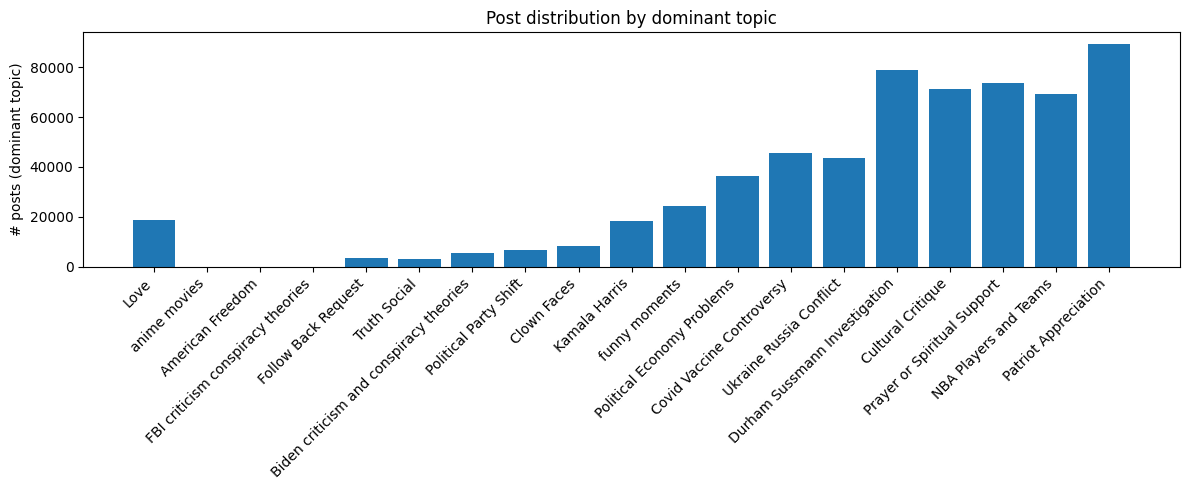

In [85]:
# Plot: post distribution by topic

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.bar(
    topic_post_counts["topic_label"],
    topic_post_counts["n_posts"]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("# posts (dominant topic)")
plt.title("Post distribution by dominant topic")
plt.tight_layout()
plt.show()

In [86]:
# User-level topic presence

# For each user, compute average topic weight
# Count topic as "present" if avg weight ≥ 0.05
user_topic_presence = (
    (df.groupby("author")[topic_cols].mean() > 0.05)  
    .sum()
)

# Extract topic ID and label
user_topic_presence = (
    user_topic_presence
    .rename("n_users")
    .reset_index()
)

user_topic_presence["topic_id"] = user_topic_presence["index"].str.replace("topic_", "").astype(int)
user_topic_presence["topic_label"] = user_topic_presence["topic_id"].map(topic_labels)

len(user_topic_presence)


20

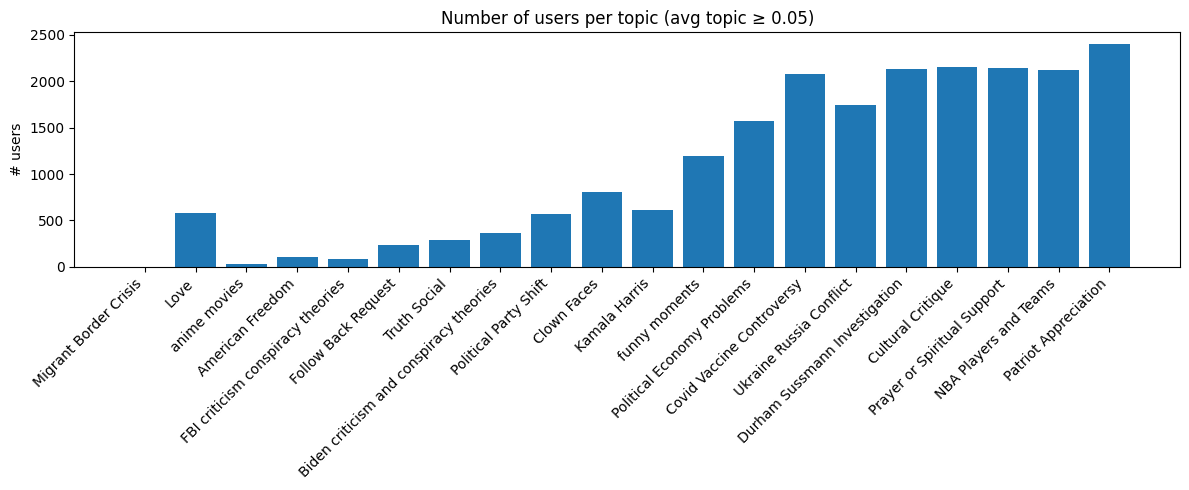

In [87]:
# Plot: number of users per topic
plt.figure(figsize=(12,5))
plt.bar(
    user_topic_presence["topic_label"],
    user_topic_presence["n_users"]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("# users")
plt.title("Number of users per topic (avg topic ≥ 0.05)")
plt.tight_layout()
plt.show()


In [88]:
df.head()

,Unnamed: 0.1,Unnamed: 0,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,...,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_main,topic_main_id,topic_id,topic_label
0,0,0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,...,0.000000,0.000000,0.000000,0.321292,0.000000,0.145132,topic_17,17,17,Prayer or Spiritual Support
1,1,1,807614,6,20054,0,0,0,enough is enough! retruth,0,...,0.000000,0.018145,0.090782,0.000000,0.105097,0.317538,topic_19,19,19,Patriot Appreciation
2,2,2,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,...,0.202165,0.000000,0.000000,0.153599,0.105702,0.000000,topic_14,14,14,Ukraine Russia Conflict
3,3,3,807622,6,20054,0,0,0,<emoji: dart><emoji: 100><emoji: us>,0,...,0.065548,0.000000,0.000000,0.516513,0.033902,0.000000,topic_17,17,17,Prayer or Spiritual Support
4,4,4,807625,5,20054,0,0,0,#truth #soros #ukraine,0,...,0.630971,0.070343,0.000000,0.000000,0.000000,0.074992,topic_14,14,14,Ukraine Russia Conflict


In [89]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'timestamp', 'author', 'like_count',
       'retruth_count', 'reply_count', 'text', 'hate_pred', 'hate_prob',
       'sentiment_id', 'sentiment_conf', 'sentiment', 'statement_flag',
       'statement_probability', 'TRUTH_CLASS_x', 'NO_STMT', 'TRUE', 'FALSE',
       'clusters', 'style_cluster', 'activity_cluster',
       'temporal_rhythm_cluster', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9',
       'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15',
       'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_main',
       'topic_main_id', 'topic_id', 'topic_label'],
      dtype='str')

In [90]:
# Drop intermediate columns
cols_to_drop = [
    "Unnamed: 0.1", "Unnamed: 0",
    "topic_0", "topic_1", "topic_2", "topic_3", "topic_4",
    "topic_5", "topic_6", "topic_7", "topic_8", "topic_9",
    "topic_10", "topic_11", "topic_12", "topic_13", "topic_14",
    "topic_15", "topic_16", "topic_17", "topic_18", "topic_19",
    "topic_main", "topic_main_id", "topic_id"
]

df_clean_final = df.drop(columns=cols_to_drop, errors="ignore")

In [91]:
df_clean_final.head()

,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,...,statement_probability,TRUTH_CLASS_x,NO_STMT,TRUE,FALSE,clusters,style_cluster,activity_cluster,temporal_rhythm_cluster,topic_label
0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,0.005426,1,...,0.010807,NaN,NaN,NaN,NaN,"[5, 5, 5, 5, 5, 5]",6.0,5.0,2.0,Prayer or Spiritual Support
1,807614,6,20054,0,0,0,enough is enough! retruth,0,0.001936,1,...,0.029001,NaN,NaN,NaN,NaN,[5],6.0,2.0,7.0,Patriot Appreciation
2,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,...,0.519844,0.0,0.943432,0.020946,0.035622,[5],6.0,2.0,7.0,Ukraine Russia Conflict
3,807622,6,20054,0,0,0,<emoji: dart><emoji: 100><emoji: us>,0,0.003288,1,...,0.011909,NaN,NaN,NaN,NaN,[5],6.0,2.0,7.0,Prayer or Spiritual Support
4,807625,5,20054,0,0,0,#truth #soros #ukraine,0,0.142274,1,...,0.035824,NaN,NaN,NaN,NaN,[5],6.0,2.0,7.0,Ukraine Russia Conflict


In [94]:
df_clean_final['topic_label']

0         Prayer or Spiritual Support
1                Patriot Appreciation
2             Ukraine Russia Conflict
3         Prayer or Spiritual Support
4             Ukraine Russia Conflict
                     ...             
596753          Political Party Shift
596754           Patriot Appreciation
596755           Patriot Appreciation
596756           Patriot Appreciation
596757           Patriot Appreciation
Name: topic_label, Length: 596758, dtype: str

In [95]:
# manual refinement of noisy LLM labels
topic_label_refined = {
    "Love": "Positive Affirmations",
    "Clown Face Reactions": "Mocking Emoji Reactions",
    "Humor and Reactions": "Humor and Social Reactions",
}

df_clean_final["topic_label"] = df_clean_final["topic_label"].replace(topic_label_refined)


In [100]:
df_clean_final["topic_label"].unique()


<StringArray>
[            'Prayer or Spiritual Support',
                    'Patriot Appreciation',
                 'Ukraine Russia Conflict',
                       'Cultural Critique',
                     'Follow Back Request',
               'Covid Vaccine Controversy',
                   'Positive Affirmations',
           'Durham Sussmann Investigation',
                   'NBA Players and Teams',
                           'Kamala Harris',
                           'funny moments',
                   'Political Party Shift',
              'Political Economy Problems',
 'Biden criticism and conspiracy theories',
                            'Truth Social',
                             'Clown Faces',
       'FBI criticism conspiracy theories',
                        'American Freedom',
                            'anime movies']
Length: 19, dtype: str

In [101]:
# Save feature file
output_path = "truthsocial_user_features.csv"

df_clean_final.to_csv(
    output_path,
    index=False
)

print(f"Saved file to: {output_path}")

Saved file to: truthsocial_user_features.csv
